In [21]:
from scipy import stats
import numpy as np
import pandas as pd

In [17]:
li = [49,58,75,110,112,132,151,276,281,362]
m0 = 200.
k = [x - m0 for x in li]

stats.wilcoxon(k,  mode='approx', alternative='two-sided')


WilcoxonResult(statistic=17.0, pvalue=0.2845026979112075)

In [18]:
nocut = [22,22,15,13,19,19,18,20,21,13,13,15]
cut = [17,18,18,15,12,4,14,15,10]

In [20]:
stats.mannwhitneyu(nocut, cut, alternative='greater')

MannwhitneyuResult(statistic=81.0, pvalue=0.02900499272087373)

In [22]:
challenger = pd.read_table('challenger.txt')

In [23]:
challenger

,Unnamed: 0,Temperature,Incident
0,Apr12.81,18.9,0
1,Nov12.81,21.1,1
2,Mar22.82,20.6,0
3,Nov11.82,20.0,0
4,Apr04.83,19.4,0
5,Jun18.83,22.2,0
6,Aug30.83,22.8,0
7,Nov28.83,21.1,0
8,Feb03.84,13.9,1
9,Apr06.84,17.2,1


In [53]:
sample1 = challenger[challenger['Incident']==0]['Temperature']
sample2 = challenger[challenger['Incident']==1]['Temperature']

In [54]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), size=(n_samples, len(data)))
    #print(data)
    #print(indices)
    
    samples = [[data.iloc[r] for r in index] for index in indices]
    return samples

In [58]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [59]:
np.random.seed(0)
b1 = (map(np.mean,get_bootstrap_samples(sample1, 1000)))
b2 = (map(np.mean,get_bootstrap_samples(sample2, 1000)))
diff_means = map(lambda x: x[1] - x[0], zip(b1, b2))
print ("#6 95% conf interval ",  stat_intervals(list(diff_means), 0.05))



#6 95% conf interval  [-7.93861607 -1.42299107]


In [60]:
def permutation_t_stat_ind(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

In [61]:
def get_random_combinations(n1, n2, max_combinations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_combinations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

In [62]:
def permutation_zero_dist_ind(sample1, sample2, max_combinations = None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    
    if max_combinations:
        indices = get_random_combinations(n1, len(sample2), max_combinations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() \
             for i in indices]
    return distr

In [64]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


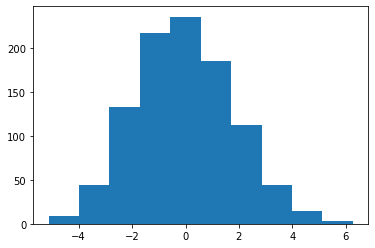

In [65]:
pylab.hist(permutation_zero_dist_ind(sample1, sample2, max_combinations = 1000))
pylab.show()

In [66]:
def permutation_test(sample, mean, max_permutations = None, alternative = 'two-sided'):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_ind(sample, mean)
    
    zero_distr = permutation_zero_dist_ind(sample, mean, max_permutations)
    
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)
    
    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

In [67]:
np.random.seed(0)


print( "p-value: %f" % permutation_test(sample1, sample2, max_permutations = 10000))

p-value: 0.007000
